In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic

/tmp/ipykernel_5421/251887701.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [10]:
generated1 = Traffic.from_file("../los_generation/traffic_MC_0.parquet")
generated2 = Traffic.from_file("../los_generation/traffic_MC_1.parquet")
generated3 = Traffic.from_file("../los_generation/traffic_MC_2.parquet")
generated4 = Traffic.from_file("../los_generation/traffic_MC_3.parquet")
generated5 = Traffic.from_file("../los_generation/traffic_MC_4.parquet")

In [ ]:
# Getting unique flight_id

generated1 = generated1.assign(flight_id = lambda df: df.flight_id + "_MC_0")
generated2 = generated2.assign(flight_id = lambda df: df.flight_id + "_MC_1")
generated3 = generated3.assign(flight_id = lambda df: df.flight_id + "_MC_2")
generated4 = generated4.assign(flight_id = lambda df: df.flight_id + "_MC_3")
generated5 = generated5.assign(flight_id = lambda df: df.flight_id + "_MC_4")

In [13]:
generated1.to_parquet("traffic_MC_0.parquet")
generated2.to_parquet("traffic_MC_1.parquet")
generated3.to_parquet("traffic_MC_2.parquet")
generated4.to_parquet("traffic_MC_3.parquet")
generated5.to_parquet("traffic_MC_4.parquet")

In [21]:
from traffic.data import airports
from ipyleaflet import  Marker, Polygon
from ipywidgets import Layout


disp_t = gen_ldng[:5] + gen_to[:5]
map = disp_t.map_leaflet()

polygon = Polygon(
    locations=[(48.580030, 2.221770), (48.437099, 2.163190), (48.293011, 2.418050), (48.267231,2.695350), (48.541458,2.660290), (48.6102599,2.474805)],
    color="green",
    fill_color="green"
)

map.add_layer(Marker(location=airports["LFPO"].latlon))

map.add_layer(polygon)

map

Map(center=[48.466445650819345, 2.424221452537494], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [19]:
count = 2
N = 1e6
p = count/N
c = np.sqrt((1-p)/(N*p)) 
print(p, c)

2e-06 0.7071060740794128


In [3]:
p = 1e-4
er = 0.1
N = (1-p)/(p*er**2)
N

999899.9999999999

In [7]:
starts_gen_to = gen_to.data.groupby("flight_id")["timestamp"].first().sort_values()
starts_gen_ldng = gen_ldng.data.groupby("flight_id")["timestamp"].first().sort_values()
ends_gen_ldng = gen_ldng.data.groupby("flight_id")["timestamp"].last().sort_values()
ends_gen_to = gen_to.data.groupby("flight_id")["timestamp"].last().sort_values()

In [8]:
print(starts_gen_to.duplicated().values.sum(), ends_gen_ldng.duplicated().values.sum())

0 0


In [9]:
print(ends_gen_ldng[-1], ends_gen_to[-1]) 

1903-03-18 07:58:55+00:00 1903-03-14 05:41:45+00:00


In [14]:
effective = gen_ldng.query('timestamp < "2025-12-02 06:53:10+0000"')
effective

,count
flight_id,
LDNG_TRAJ_185756,375
LDNG_TRAJ_126039,375
LDNG_TRAJ_21767,375
LDNG_TRAJ_170421,375
LDNG_TRAJ_141198,375
LDNG_TRAJ_1948,375
LDNG_TRAJ_110873,375
LDNG_TRAJ_151980,375
LDNG_TRAJ_152167,375


# Time differences between pairs takeoffs/landings

In [33]:
import pandas as pd

delta_t = []

# first landings
for iL, tL in tqdm(starts_gen_ldng[:5000].items()):
    for iT, tT in starts_gen_to[:5000].items():
        d = tL - tT

        #If delta_t is posiive, takeoff starts AFTER landing, and then delta_t cannot be larger than landing duration
        #If delta_t is negative, takeoff starts BEFORE landing, and then delta_t cannot be larger than takeoff duration (absolute value)
        if d < tT - ends_gen_to[iT] or (d > ends_gen_ldng[iL] - tL):
            pass

        #make sure that delta_t is smaller than the total duration of the reference (the takeoff)
        elif d < ends_gen_ldng[iL] - tL: 
            delta_t.append({"takeoff": iT, "landing":iL, "delta_t":d.total_seconds()})

delta_t = pd.DataFrame(delta_t)

0it [00:00, ?it/s]

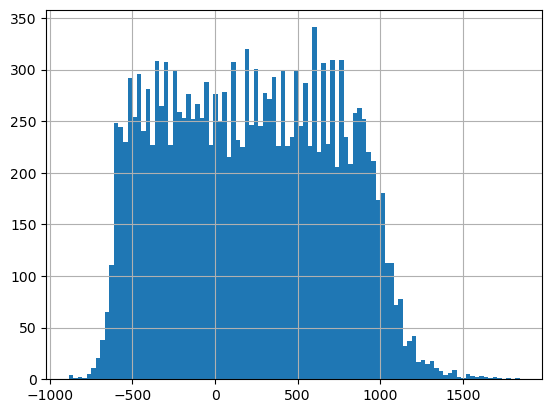

In [34]:
delta_t.delta_t.hist(bins = 100)
plt.show()

Delta_t between pairs is pretty similar when parametrizing flows or directly estimating the delta_t between pairs

# Horizontal intersection

In [4]:
n = 5000
small_to = gen_to[:n]
small_landing = gen_ldng[:n]

In [5]:
import pandas as pd
from shapely.geometry import LineString, Point
from tqdm.autonotebook import tqdm 

intersect = []

for f1, f2 in tqdm(zip(small_to, small_landing)):
    inter = f1.shape.intersection(f2.shape)
    if isinstance(inter, Point):
        intersect.append({"lat": inter.y, "lon":inter.x})


0it [00:00, ?it/s]

In [12]:
from traffic.data import airports
from ipyleaflet import Map, basemaps, Marker, MarkerCluster, Polygon
from ipywidgets import Layout



map_ = Map(
    center=airports["LFPO"].latlon,
    zoom=10,
    basemap=basemaps.Stamen.Terrain,
    layout=Layout(width="100%", height="1000px"),
)

# for i in range(10):
#     map_.add_layer(small_to[i])
#     map_.add_layer(small_landing[i])

markers = []
for l in intersect[:1000]:
    markers.append(Marker(location=(l["lat"], l["lon"]))) 

marker_cluster = MarkerCluster(
    markers=markers
)
map_.add_layer(marker_cluster)

lat = [48.580030,48.437099,48.293011,48.267231,48.541458, 48.6102599]
lon = [2.221770,2.163190,2.418050,2.695350, 2.660290, 2.474805]

# boundings of bbox based on cities: Egly, Etampes, Malesherbes, Nemours, Melun, Corbeil-Essonnes
polygon = Polygon(
    locations=[(48.580030, 2.221770), (48.437099, 2.163190), (48.293011, 2.418050), (48.267231,2.695350), (48.541458,2.660290), (48.6102599,2.474805)],
    color="green",
    fill_color="green"
)

map_.add_layer(polygon)

map_

Map(center=[48.7233333, 2.3794444], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [7]:
from shapely.geometry import Polygon

df_intersect = pd.DataFrame(intersect)
lat_min, lat_max, lon_min, lon_max = df_intersect.lat.min(), df_intersect.lat.max(), df_intersect.lon.min(), df_intersect.lon.max()

lat = [lat_min, lat_max, lat_max, lat_min]
lon = [lon_min, lon_min, lon_max, lon_max]
poly = Polygon(zip(lon, lat))

In [ ]:
# boundings of bbox based on cities: Egly, Etampes, Malesherbes, Nemours, Melun, Corbeil-Essonnes
lat = [48.580030,48.437099,48.293011,48.267231,48.541458, 48.6102599]
lon = [2.221770,2.163190,2.418050,2.695350, 2.660290, 2.474805]

In [9]:
t_cropped = generated.inside_bbox((poly))

In [10]:
t_cropped.to_pickle("test_MC_orly_bbox.pkl")

In [11]:
t_cropped

,count
flight_id,
LDNG_TRAJ_193702,1470
LDNG_TRAJ_126342,1452
LDNG_TRAJ_52448,1451
LDNG_TRAJ_72108,1444
LDNG_TRAJ_7748,1444
LDNG_TRAJ_178280,1444
LDNG_TRAJ_19429,1443
LDNG_TRAJ_175616,1438
LDNG_TRAJ_90633,1438
